<a href="https://colab.research.google.com/github/binhluong84/Machine-Learning/blob/main/INSURANCE_PREDICT_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [ ]:
#Connect Google Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
ins = pd.read_csv('/gdrive/MyDrive/INSURANCE REGION PREDICT/insurance.csv')


In [ ]:
ins.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
ins.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [ ]:
## kiểm tra số dòng, số cột:
print("There are {:,} observations and {} columns in the data set.".format(ins.shape[0], ins.shape[1]))

There are 1,338 observations and 7 columns in the data set.


In [ ]:
## kiểm tra missig value:
print("There are {} missing values in the data.".format(ins.isna().sum().sum()))

There are 0 missing values in the data.


In [ ]:
## kiểm tra dtype của các trường mang giá trị object:
ins.select_dtypes(include=['object']).describe()

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [ ]:
## lựa chọn trường có dtype = object:
cat=ins.select_dtypes(include=['object']).columns.tolist()

## vòng lặp đếm giá trị trong các trường có dtype = object:
for i in cat:
    obs=ins[i].value_counts()
    avg_claim=ins.groupby(i)["charges"].mean()
    display(pd.DataFrame({"Number of Policyholders":obs, "Average Claim Amount":avg_claim.map('${:,.2f}'.format)})\
            .sort_values('Number of Policyholders', ascending=False)\
            .style.set_caption("Variable: {}".format(i)))

,Number of Policyholders,Average Claim Amount
male,676,"$13,956.75"
female,662,"$12,569.58"


,Number of Policyholders,Average Claim Amount
no,1064,"$8,434.27"
yes,274,"$32,050.23"


,Number of Policyholders,Average Claim Amount
southeast,364,"$14,735.41"
northwest,325,"$12,417.58"
southwest,325,"$12,346.94"
northeast,324,"$13,406.38"


In [ ]:
## PHÂN TÍCH DỮ LIỆU
## đồ thị biểu diễn tổng charge cho từng khu vực:
init_notebook_mode(connected=True)
px.defaults.template = "plotly_white"
plot_df=ins.copy()
fig = px.box(plot_df, x="region", y="charges", color="region", 
             notched=True, points="outliers", height=600,
             title="Distribution of Insurance Costs by Region",
             color_discrete_sequence=['#B14B51', '#D0A99C', '#5D8370', '#6C839B'])
fig.show(renderer="colab")

In [ ]:
## đồ thị biểu diễn tổng charge cho từng giới tính:
init_notebook_mode(connected=True)
px.defaults.template = "plotly_white"
plot_df=ins.copy()
fig = px.box(plot_df, x="sex", y="charges", color="sex", 
             notched=True, points="outliers", height=600,
             title="Distribution of Insurance Costs by sex",
             color_discrete_sequence=['#B14B51', '#D0A99C', '#5D8370', '#6C839B'])
fig.show(renderer="colab")

In [ ]:
## biểu đồ histogram phân cho hút thuốc hoặc không hút thuốc:
fig=px.histogram(ins, x='charges', color='smoker', opacity=0.7, barmode='overlay',
                 histnorm='probability density', marginal='box', 
                 title="Distribution of Insurance Costs by Smoking Status",
                 color_discrete_sequence=['#B14B51','#B7A294']) 
fig.update_layout(font_color="#303030", xaxis_title='Claim Amount, $',
                  yaxis=dict(title='Probability Density', gridcolor='#EAEAEA', zerolinecolor='#EAEAEA'),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""))
fig.update_xaxes(showgrid=False, zerolinecolor='#EAEAEA')
fig.show(renderer="colab")

In [ ]:
## biểu diễn charge theo nhóm độ tuổi
## phân nhóm độ tuổi
plot_df = ins.copy()
plot_df["Age_Group"]=['18 to 29 years' if i<30 else '30 to 44 years' if (i>=30)&(i<45) else 
                      '45 to 59 years' if (i>=45)&(i<60) else '60 and over' for i in ins['age']]

## dựng đồ thị charge cho từng nhóm tuổi:
plot_df = plot_df.groupby(['Age_Group','smoker'])['charges'].mean()
plot_df = plot_df.rename('charges').reset_index().sort_values('smoker', ascending=True)
fig = px.bar(plot_df, x='Age_Group', y='charges', color='smoker', height=500, text='charges', 
             opacity=0.75, barmode='group', color_discrete_sequence=['#B7A294','#B14B51'],
             title="Average Insurance Costs by Age and Smoking Status")

## thay đổi các thông số cho đồ thị:
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside', 
                  marker_line=dict(width=1, color='#303030'))
fig.update_layout(font_color="#303030",bargroupgap=0.05, bargap=0.3, 
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""),
                  xaxis=dict(title='Age',showgrid=False), 
                  yaxis=dict(title='Claim Amount, $', showgrid=False,zerolinecolor='#DBDBDB',
                             showline=True, linecolor='#DBDBDB', linewidth=2))
fig.show(renderer="colab")

In [ ]:
## BIỂU ĐỒ HIỂN THỊ CHARGE THEO BMI PHÂN THEO HAI NHÓM HÚT THUỐC VÀ KHÔNG HÚT THUỐC:
## dựng biểu đồ:
fig = px.scatter(ins, x='bmi', y='charges', color='smoker', size='charges',
                 title="Insurance costs increase with Body Mass Index among Smokers",
                 color_discrete_sequence=['#B14B51','#B7A294'],height=600)

## thay đổi các tham số cho đồ thị:
fig.update_layout(legend=dict(title='',orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                  font_color="#303030", xaxis=dict(title='Body Mass Index (BMI)',showgrid=False), 
                  yaxis=dict(title='Claim Amount, $',showgrid=False, zerolinecolor='#E5E5EA',
                             showline=True, linecolor='#E5E5EA', linewidth=2))
fig.show(renderer="colab")

In [ ]:
## biểu đồ số tổng số phí charge cho từng khu vực phân theo giới tính:
plot_df = ins.groupby(['region','sex','smoker'])['charges'].mean()
plot_df = plot_df.rename('charges').reset_index()
fig = px.bar(plot_df, x='region', y='charges', color='sex', height=800,
             title="Average Insurance Costs by Region and Smoking Status",
             color_discrete_map={'Female': '#BFC5DA','Male': '#5D6A92'}, 
             facet_row='smoker', text='charges', opacity=0.85, barmode='group')
## thay đổi tham số đồ thị:
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside', 
                  marker_line=dict(width=1, color='#303030'))
fig.layout.yaxis2.update(matches=None)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(title="Region", row=1)
fig.update_yaxes(title="Claim Amount, $",  gridcolor='#E3E3E3', zeroline=True, zerolinewidth=2, 
                 showgrid=False, zerolinecolor='#E5E5EA',
                 showline=True, linecolor='#E5E5EA', linewidth=2)
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white",
                  bargroupgap=0.05, bargap=0.2,
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""))
fig.show(renderer="colab")

In [ ]:
ins['female'] = ins['sex'].apply(lambda x: 1 if x=='male' else 0)


In [ ]:
ins['smoker_yes'] = ins['smoker'].apply(lambda x: 1 if x=='no' else 0)
ins.drop(['sex', 'smoker'], axis=1, inplace=True)
ins.head()

,age,bmi,children,region,charges,female,smoker_yes
0,19,27.900,0,southwest,16884.92400,0,0
1,18,33.770,1,southeast,1725.55230,1,1
2,28,33.000,3,southeast,4449.46200,1,1
3,33,22.705,0,northwest,21984.47061,1,1
4,32,28.880,0,northwest,3866.85520,1,1


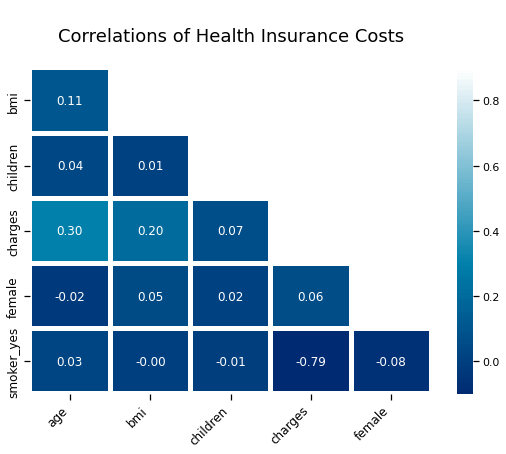

In [ ]:
## DỰNG BIỂU ĐỒ TƯƠNG QUAN:
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(9,6))   
corr=ins.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr=corr.iloc[1:,:-1].copy()
ax=sns.heatmap(corr, mask=mask, vmin=-.1, vmax=.9, center=0, annot=True, fmt='.2f', 
               cmap='ocean', linewidths=4, annot_kws={"fontsize":12})
ax.set_title('\nCorrelations of Health Insurance Costs\n', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
fig.show()

In [ ]:
## HỒI QUY TUYẾN TÍNH VỚI PCA (HỒI QUY GIẢM CHIỀU DỮ LIỆU)
## đặt biển model:
models=["Linear Regression", "KNN", "SVM", "Gradient Boosting"]
mod_res=pd.DataFrame(columns=["Average RMSE", "Avg. Adjusted R2"], index=models)
regions = ins.region.unique()
s = StandardScaler()
actuals=[]
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]

for i in regions:
    ## tách X và y từ tệp data:
    # Filter data by region
    print("\nRegion: {}\n".format(i))
    ins_df = ins[ins.region==i]
    X=ins_df.drop(['charges', 'region'], axis=1)
    y=ins_df.charges
      # Add polynomial features
    ## thêm các tùy chọn và tranform X:
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns))
        # Create training and test sets
        ## tách x_train, y_train, x_test, y_test:
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
        # Scale features
        ## scale X:
    X_train_scaled = s.fit_transform(X_train)
    X_test_scaled = s.transform(X_test)
        # PCA
        ## GIẢM CHIỀU DỮ LIỆU:
    pca = PCA(.95)
    X_train_pca=pca.fit_transform(X_train_scaled)
    X_test_pca=pca.transform(X_test_scaled)
    print("Number of Principal Components = {}".format(pca.n_components_))
    print("Train Shape:{} {}  Test Shape:{} {}".format(X_train_pca.shape, y_train.shape, X_test_pca.shape, y_test.shape))
       # Linear Regression
       ##  
    lr = LinearRegression().fit(X_train_pca, y_train)
    y_pred=lr.predict(X_test_pca)
    rmse=np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2=r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test_pca.shape[1]-1)
    
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
      
    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))
    if i != 'Northeast':
        print("__________________________")





Region: southwest

Number of Principal Components = 5
Train Shape:(260, 5) (260,)  Test Shape:(65, 5) (65,)
Test Error (RMSE) = 5,661.48
R-Squared = 76.64%, Adjusted R-Squared = 74.66%
__________________________

Region: southeast

Number of Principal Components = 6
Train Shape:(291, 6) (291,)  Test Shape:(73, 6) (73,)
Test Error (RMSE) = 4,607.97
R-Squared = 90.69%, Adjusted R-Squared = 89.84%
__________________________

Region: northwest

Number of Principal Components = 5
Train Shape:(260, 5) (260,)  Test Shape:(65, 5) (65,)
Test Error (RMSE) = 5,697.99
R-Squared = 79.12%, Adjusted R-Squared = 77.35%
__________________________

Region: northeast

Number of Principal Components = 5
Train Shape:(259, 5) (259,)  Test Shape:(65, 5) (65,)
Test Error (RMSE) = 6,296.14
R-Squared = 62.51%, Adjusted R-Squared = 59.33%
__________________________


In [ ]:
# Plot results
## HIỂN THỊ KẾT QUẢ DỰ ĐOÁN GIỮA X_TRAIN VÀ Y_PREDS:
for i in range(0,4):
    actuals[i].loc[:,'index']=regions[i]
actual = pd.concat([actuals[i] for i in range(4)], axis = 0)
pred = pd.concat([preds[i] for i in range(4)], axis = 0)
df = pd.concat([actual, pred], axis=1).reset_index(drop=True)
col = ["#B14B51", '#D0A99C', '#5D8370','#6C839B']
fig = px.scatter(df, x="actuals", y="preds", color="index", trendline="ols", height=700,
                 title="Actual vs Predicted Insurance Costs by Region,<br>Linear Regression with Principal Component Analysis",
                 color_discrete_sequence=col, opacity=0.7, facet_col='index', facet_col_wrap=2)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[0]*100,rmses[0]),
                   x=51e3,y=15e3, row=2,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[1]*100,rmses[1]),
                   x=51e3,y=15e3, row=2,col=2, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[3]*100,rmses[3]),
                   x=51e3,y=15e3, row=1,col=2, showarrow=False)

fig.update_traces(hovertemplate="Actual Cost: %{x:$,.2f}<br>Predicted Cost: %{y:$,.2f}",
                  marker=dict(size=10, line=dict(width=1,color="#F7F7F7")),
                  selector=dict(mode="markers"), showlegend=False)
fig.update_xaxes(title="Actual Cost, $", row=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#EAEAEA',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_yaxes(title="Predicted Cost, $", col=1)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E3E3E3',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white")
fig.show(renderer="colab")

In [ ]:
## HIỂN THỊ KẾT QUẢ:
mod_res.iloc[0,0]=pd.Series(rmses).mean()
mod_res.iloc[0,1]=pd.Series(adj_r2_scores).mean()
display(mod_res.iloc[:1,].sort_values("Average RMSE"))

,Average RMSE,Avg. Adjusted R2
Linear Regression,5565.895,0.752981


In [ ]:
## K-NEAREST NEIGHTBORS REGRESSION
actuals=[]
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]
for i in regions:
    
    # Filter data by region
    ## tách dữ liệu và đặt biến X, y theo vùng:
    ins_df = ins[ins.region==i]
    X=ins_df.drop(['charges', 'region'], axis=1)
    y=ins_df.charges
    
    # Add polynomial features
    ## Thêm các biến mới
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns)) 
    
      # Create training and test sets
    ## tách train và test:
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
    X_train = pd.DataFrame(X_train, columns = X_pf.columns)
    X_test = pd.DataFrame(X_test, columns = X_pf.columns)
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    print("\nRegion: {}\n".format(i))
    print("Train Shape:{} {}  Test Shape:{} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    ## Scale dữ liệu: 
     # Scale features
    X_train = pd.DataFrame(data=s.fit_transform(X_train), columns=X_pf.columns)
    X_test = pd.DataFrame(data=s.transform(X_test), columns=X_pf.columns)
    


Region: southwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)

Region: southeast

Train Shape:(291, 20) (291,)  Test Shape:(73, 20) (73,)

Region: northwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)

Region: northeast

Train Shape:(259, 20) (259,)  Test Shape:(65, 20) (65,)


In [ ]:
 # KNN
 ## SET THÔNG SỐ CHO KNN
grid = {'n_neighbors': range(2, 20),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [int(x) for x in np.linspace(10, 50, num = 5)],
            'p': [1, 2]}

In [ ]:
actuals=[]
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]

for i in regions:
    
    # Filter data by region
    ins_df = ins[ins.region==i]
    X=ins_df.drop(['charges', 'region'], axis=1)
    y=ins_df.charges
    
    # Add polynomial features
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns))
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
    X_train = pd.DataFrame(X_train, columns = X_pf.columns)
    X_test = pd.DataFrame(X_test, columns = X_pf.columns)
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    print("\nRegion: {}\n".format(i))
    print("Train Shape:{} {}  Test Shape:{} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    
    # Scale features
    X_train = pd.DataFrame(data=s.fit_transform(X_train), columns=X_pf.columns)
    X_test = pd.DataFrame(data=s.transform(X_test), columns=X_pf.columns)
    
    # KNN
    grid = {'n_neighbors': range(2, 20),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [int(x) for x in np.linspace(10, 50, num = 5)],
            'p': [1, 2]}
    knn=KNeighborsRegressor()
    knn_cv=RandomizedSearchCV(estimator=knn, param_distributions=grid, scoring='neg_mean_squared_error', 
                              n_iter=100, cv=3, random_state=21, n_jobs=-1)
    knn_cv.fit(X_train, y_train)
    y_pred=knn_cv.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse=np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2=r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))
    if i != 'Northeast':
        print("__________________________")

## DỰNG ĐỒ THỊ KẾT QUẢ:
# Plot results
for i in range(0,4):
    actuals[i].loc[:,'index']=regions[i]
actual = pd.concat([actuals[i] for i in range(4)], axis = 0)
pred = pd.concat([preds[i] for i in range(4)], axis = 0)
df = pd.concat([actual, pred], axis=1).reset_index(drop=True)

fig = px.scatter(df, x="actuals", y="preds", color="index", trendline="lowess", height=700,
                 title="Actual vs Predicted Insurance Costs by Region,<br>K-Nearest Neighbors",
                 color_discrete_sequence=col, opacity=0.7, facet_col='index', facet_col_wrap=2)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[0]*100,rmses[0]),
                   x=51e3,y=15e3, row=2,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[1]*100,rmses[1]),
                   x=51e3,y=15e3, row=2,col=2, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[2]*100,rmses[2]),
                   x=51e3,y=15e3, row=1,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[3]*100,rmses[3]),
                   x=51e3,y=15e3, row=1,col=2, showarrow=False)

fig.update_traces(hovertemplate="Actual Cost: %{x:$,.2f}<br>Predicted Cost: %{y:$,.2f}",
                  marker=dict(size=10,line=dict(width=1,color="#F7F7F7")),
                  selector=dict(mode="markers"), showlegend=False)
fig.update_xaxes(title="Actual Cost, $", row=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#EAEAEA',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_yaxes(title="Predicted Cost, $", col=1)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E3E3E3',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white")
fig.show(renderer="colab")


Region: southwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 4,634.25
R-Squared = 84.35%, Adjusted R-Squared = 77.24%
__________________________

Region: southeast

Train Shape:(291, 20) (291,)  Test Shape:(73, 20) (73,)
Test Error (RMSE) = 4,277.54
R-Squared = 91.98%, Adjusted R-Squared = 88.89%
__________________________

Region: northwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 5,853.5
R-Squared = 77.97%, Adjusted R-Squared = 67.95%
__________________________

Region: northeast

Train Shape:(259, 20) (259,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 5,555.43
R-Squared = 70.81%, Adjusted R-Squared = 57.54%
__________________________


In [ ]:
## SO SÁNH HAI PHƯƠNG PHÁP:
mod_res.iloc[1,0]=pd.Series(rmses).mean()
mod_res.iloc[1,1]=pd.Series(adj_r2_scores).mean()
display(mod_res.iloc[:2,].sort_values("Average RMSE"))

,Average RMSE,Avg. Adjusted R2
KNN,5080.18,0.729063
Linear Regression,5565.895,0.752981


In [ ]:
## SUPPORT VECTOR REGRESSION
## đặt trước thông số
actuals=[]
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]
feat_importance=pd.DataFrame()

## tạo vòng lặp:
for i in regions:
    
    print("\nRegion: {}\n".format(i))
    
    ## chia dữ liệu theo 'region':
    # Filter data by region
    ins_df = ins[ins.region==i]
    X=ins_df.drop(['charges', 'region'], axis=1)
    y=ins_df.charges
    
    ## thêm bước xử lý dữ liệu: 
    # Add polynomial features
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns))
    
    ## tạo train và test:
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
    X_train = pd.DataFrame(X_train, columns = X_pf.columns)
    X_test = pd.DataFrame(X_test, columns = X_pf.columns)
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    
    # Scale features
    X_train = pd.DataFrame(data=s.fit_transform(X_train), columns=X_pf.columns)
    X_test = pd.DataFrame(data=s.transform(X_test), columns=X_pf.columns)
    
    ## chạy SVM: 
    # Tuning SVM
    grid = {'kernel':['linear','rbf','poly','sigmoid'],
            'C': np.logspace(-3, 3, 10),
            'gamma':np.logspace(-3, 3, 10)}
    svm = SVR()
    svm_cv=RandomizedSearchCV(estimator=svm, param_distributions=grid, scoring='neg_mean_squared_error', 
                              n_iter=10, cv=3, random_state=21, n_jobs=-1)
    svm_cv.fit(X_train, y_train)
    print("Best SVM Parameters:\n",svm_cv.best_params_)
    y_pred=svm_cv.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse=np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2=r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    ## In kết quả:
    print("\nTest Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))
    if i != 'Northeast':
        print("__________________________")

        ## Đồ thị mô tả hồi quy:
# Plot results
for i in range(0,4):
    actuals[i].loc[:,'index']=regions[i]
actual = pd.concat([actuals[i] for i in range(4)], axis = 0)
pred = pd.concat([preds[i] for i in range(4)], axis = 0)
df = pd.concat([actual, pred], axis=1).reset_index(drop=True)

fig = px.scatter(df, x="actuals", y="preds", color="index", trendline="lowess", height=700,
                 title="Actual vs Predicted Insurance Costs by Region,<br>Support Vector Regression",
                 color_discrete_sequence=col, opacity=0.7, facet_col='index', facet_col_wrap=2)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[0]*100,rmses[0]),
                   x=51e3,y=15e3, row=2,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[1]*100,rmses[1]),
                   x=51e3,y=15e3, row=2,col=2, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[2]*100,rmses[2]),
                   x=51e3,y=15e3, row=1,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[3]*100,rmses[3]),
                   x=51e3,y=15e3, row=1,col=2, showarrow=False)

fig.update_traces(hovertemplate="Actual Cost: %{x:$,.2f}<br>Predicted Cost: %{y:$,.2f}",
                  marker=dict(size=10,line=dict(width=1,color="#F7F7F7")),
                  selector=dict(mode="markers"), showlegend=False)
fig.update_xaxes(title="Actual Cost, $", row=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#EAEAEA',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_yaxes(title="Predicted Cost, $", col=1)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E3E3E3',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white")
fig.show(renderer="colab")



Region: southwest

Best SVM Parameters:
 {'kernel': 'poly', 'gamma': 10.0, 'C': 0.021544346900318832}

Test Error (RMSE) = 4,830.09
R-Squared = 83.00%, Adjusted R-Squared = 75.27%
__________________________

Region: southeast

Best SVM Parameters:
 {'kernel': 'poly', 'gamma': 10.0, 'C': 0.021544346900318832}

Test Error (RMSE) = 4,166.61
R-Squared = 92.39%, Adjusted R-Squared = 89.46%
__________________________

Region: northwest

Best SVM Parameters:
 {'kernel': 'poly', 'gamma': 10.0, 'C': 0.021544346900318832}

Test Error (RMSE) = 5,820.75
R-Squared = 78.21%, Adjusted R-Squared = 68.31%
__________________________

Region: northeast

Best SVM Parameters:
 {'kernel': 'poly', 'gamma': 10.0, 'C': 0.021544346900318832}

Test Error (RMSE) = 4,708.6
R-Squared = 79.03%, Adjusted R-Squared = 69.50%
__________________________


In [ ]:
## SO SÁNH KẾT QUẢ CÁC PHƯƠNG PHÁP HỒI QUY:
mod_res.iloc[2,0]=pd.Series(rmses).mean()
mod_res.iloc[2,1]=pd.Series(adj_r2_scores).mean()
display(mod_res.iloc[:3,].sort_values("Average RMSE"))

,Average RMSE,Avg. Adjusted R2
SVM,4881.5125,0.756359
KNN,5080.18,0.729063
Linear Regression,5565.895,0.752981


In [ ]:
actuals=[]
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]
feat_importance=pd.DataFrame()

for i in regions:
    
    # Filter data by region
    ins_df = ins[ins.region==i]
    X=ins_df.drop(['charges', 'region'], axis=1)
    y=ins_df.charges
    
    # Add polynomial features
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pd.DataFrame(data=pf.fit_transform(X), columns=pf.get_feature_names(X.columns))
    
    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
    X_train = pd.DataFrame(X_train, columns = X_pf.columns)
    X_test = pd.DataFrame(X_test, columns = X_pf.columns)
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    print("\nRegion: {}\n".format(i))
    print("Train Shape:{} {}  Test Shape:{} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    
    # Scale features
    X_train = pd.DataFrame(data=s.fit_transform(X_train), columns=X_pf.columns)
    X_test = pd.DataFrame(data=s.transform(X_test), columns=X_pf.columns)
    
    # Tuning 
    grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5],
            'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],
            'subsample': [0.5, 0.8, 1],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_depth': [int(x) for x in np.linspace(2, 10, num = 5)],
            'max_features': [None, 'sqrt']}
    xgb=GradientBoostingRegressor(random_state=21)
    xgb_cv=RandomizedSearchCV(estimator=xgb, param_distributions=grid, scoring='neg_mean_squared_error', 
                              n_iter=100, cv=3, random_state=21, n_jobs=-1)
    xgb_cv.fit(X_train, y_train)
    y_pred=xgb_cv.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse=np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2=r2_score(y_test, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    
    # Save feature importance
    feat_importance["Importance_"+str(i)]=xgb_cv.best_estimator_.feature_importances_
    
    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))
    if i != 'Northeast':
        print("__________________________")

# Plot results
for i in range(0,4):
    actuals[i].loc[:,'index']=regions[i]
actual = pd.concat([actuals[i] for i in range(4)], axis = 0)
pred = pd.concat([preds[i] for i in range(4)], axis = 0)
df = pd.concat([actual, pred], axis=1).reset_index(drop=True)

fig = px.scatter(df, x="actuals", y="preds", color="index", trendline="lowess", height=700,
                 title="Actual vs Predicted Insurance Costs by Region,<br>Gradient Boosting",
                 color_discrete_sequence=col, opacity=0.7, facet_col='index', facet_col_wrap=2)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[0]*100,rmses[0]),
                   x=51e3,y=15e3, row=2,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[1]*100,rmses[1]),
                   x=51e3,y=15e3, row=2,col=2, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[2]*100,rmses[2]),
                   x=51e3,y=15e3, row=1,col=1, showarrow=False)
fig.add_annotation(text="Adj. R-Squared = {:.1f}%<br>RMSE = {:,.0f}".format(adj_r2_scores[3]*100,rmses[3]),
                   x=51e3,y=15e3, row=1,col=2, showarrow=False)

fig.update_traces(hovertemplate="Actual Cost: %{x:$,.2f}<br>Predicted Cost: %{y:$,.2f}",
                  marker=dict(size=10,line=dict(width=1,color="#F7F7F7")),
                  selector=dict(mode="markers"), showlegend=False)
fig.update_xaxes(title="Actual Cost, $", row=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#EAEAEA',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_yaxes(title="Predicted Cost, $", col=1)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E3E3E3',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white")
fig.show(renderer="colab")


Region: southwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 4,644.12
R-Squared = 84.28%, Adjusted R-Squared = 77.14%
__________________________

Region: southeast

Train Shape:(291, 20) (291,)  Test Shape:(73, 20) (73,)
Test Error (RMSE) = 3,345.08
R-Squared = 95.09%, Adjusted R-Squared = 93.21%
__________________________

Region: northwest

Train Shape:(260, 20) (260,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 4,801.7
R-Squared = 85.17%, Adjusted R-Squared = 78.44%
__________________________

Region: northeast

Train Shape:(259, 20) (259,)  Test Shape:(65, 20) (65,)
Test Error (RMSE) = 5,492.81
R-Squared = 71.47%, Adjusted R-Squared = 58.50%
__________________________


In [ ]:
## SO SÁNH KẾT QUẢ CÁC PHƯƠNG PHÁP HỒI QUY:
mod_res.iloc[3,0]=pd.Series(rmses).mean()
mod_res.iloc[3,1]=pd.Series(adj_r2_scores).mean()
mod_res["Average RMSE"]=mod_res["Average RMSE"].map('{:,.2f}'.format)
mod_res["Avg. Adjusted R2"]=mod_res["Avg. Adjusted R2"].mul(100).map('{:.2f}%'.format)
display(mod_res.sort_values("Average RMSE"))

,Average RMSE,Avg. Adjusted R2
Gradient Boosting,"4,570.93",76.82%
SVM,"4,881.51",75.64%
KNN,"5,080.18",72.91%
Linear Regression,"5,565.90",75.30%


In [ ]:
col=sns.color_palette("magma", 20).as_hex()[::-1]
feat_importance.set_index(X_train.columns, inplace=True)
ft=pd.DataFrame({"Average Importance":feat_importance.mean(axis=1)})
plot_df=ft.nlargest(20, columns="Average Importance").sort_values(by="Average Importance",ascending=False)
fig = px.bar(plot_df, x="Average Importance", y=plot_df.index, text="Average Importance", height=700,
             color=plot_df.index,width=700,opacity=.8,color_discrete_sequence=col)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside',
                  marker_line=dict(width=1, color='#3F3B3A'), showlegend=False, 
                  hovertemplate='Importance = <b>%{x:.2}</b>')
fig.update_layout(title_text='Feature Importance in Predicting Health Insurance Costs', 
                  coloraxis_showscale=False, yaxis_title="", font_color="#303030", yaxis_linecolor="#D8D8D8", 
                  xaxis=dict(title="Average Feature Importance", showgrid=True, showline=True, 
                             linecolor="#9A9A9A", gridcolor="#F5F5F5"))
fig.show(renderer="colab")